Inception v3

This time:
1. train top only for 3 epochs
2. unfreeze some layers and train
3. unfreeze all layers and train with small LR

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

In [2]:
im_size = 512
batch_size = 32
seed = 666

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   validation_split=0.1, 
                                   horizontal_flip=True,
                                   vertical_flip=True, 
                                   rotation_range=360,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, 
                                   shear_range=0.1,
                                   )

train_generator = train_datagen.flow_from_directory(directory="/home/jupyter/train_process",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    target_size=(im_size, im_size),
                                                    shuffle=True,
                                                    seed=seed,
                                                    subset='training'
                                                    )

dev_generator = train_datagen.flow_from_directory(directory="/home/jupyter/train_process",
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                target_size=(im_size, im_size),
                                                shuffle=True,
                                                seed=seed,
                                                subset='validation'
                                                )

Found 34016 images belonging to 5 classes.
Found 3777 images belonging to 5 classes.


In [12]:
num_train_steps = train_generator.n // train_generator.batch_size
num_dev_steps = dev_generator.n // dev_generator.batch_size

In [14]:
# download new weights: https://github.com/fchollet/deep-learning-models/releases/tag/v0.5
local_weights_file = '/home/jupyter/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(input_shape=(512, 512, 3), 
                         weights=None, 
                         include_top=False)

base_model.load_weights(local_weights_file)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

W0827 08:59:57.241756 139857222027008 deprecation.py:323] From <ipython-input-8-5fb76967e779>:15: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [15]:
%%time

num_epochs = 20

#metrics = Metrics()
#history = LossHistory()

history = model.fit_generator(train_generator,
                    validation_data = dev_generator,
                    steps_per_epoch = num_train_steps,
                    epochs = num_epochs,
                    validation_steps = num_dev_steps,
                    verbose = 1)

Epoch 1/20
1063/1063 [==============================] - 2052s 2s/step - loss: 1.8892 - acc: 0.5149 - val_loss: 1.8880 - val_acc: 0.6012
Epoch 2/20
1063/1063 [==============================] - 2076s 2s/step - loss: 1.8195 - acc: 0.6290 - val_loss: 1.7926 - val_acc: 0.5299
Epoch 3/20
1063/1063 [==============================] - 2034s 2s/step - loss: 1.7142 - acc: 0.6041 - val_loss: 1.8731 - val_acc: 0.3530
Epoch 4/20
1063/1063 [==============================] - 2039s 2s/step - loss: 1.3556 - acc: 0.6315 - val_loss: 1.3917 - val_acc: 0.7256
Epoch 5/20
1063/1063 [==============================] - 2024s 2s/step - loss: 1.1431 - acc: 0.6727 - val_loss: 1.6271 - val_acc: 0.7180
Epoch 6/20
1063/1063 [==============================] - 2020s 2s/step - loss: 1.0842 - acc: 0.6674 - val_loss: 1.5760 - val_acc: 0.7195
Epoch 7/20
1063/1063 [==============================] - 2015s 2s/step - loss: 1.0721 - acc: 0.6866 - val_loss: 1.2604 - val_acc: 0.7201
Epoch 8/20
1063/1063 [==========================

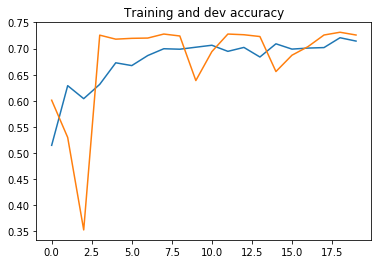

In [ ]:
# Retrieve a list of list results on training and test data sets for each training epoch
acc = history.history['acc']
dev_acc = history.history['val_acc']
loss = history.history['loss']
dev_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, dev_acc)
plt.title('Training and dev accuracy')
plt.savefig('acc_kappa.png')

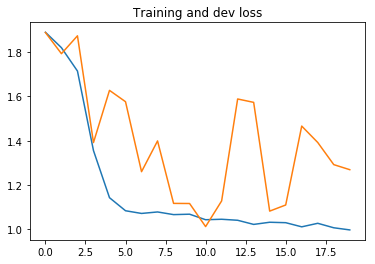

In [ ]:
# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, dev_loss)
plt.title('Training and dev loss')
plt.savefig('loss_kappa.png')

In [ ]:
model.save('model_0.h5') 
#model.save_weights('model_0_weights.h5')

In [3]:
model = tf.keras.models.load_model('model_0.h5')

W0827 22:36:27.778255 139808980612864 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 22:36:27.780149 139808980612864 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 22:36:27.781179 139808980612864 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [44]:
# apply to validation set
val_datagen = ImageDataGenerator(rescale=1/255.)

batch_size=1
val_generator = val_datagen.flow_from_directory(directory="/home/jupyter/val_process",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    target_size=(im_size, im_size),
                                                    shuffle=False,
                                                    seed=seed
                                                    )

num_val_steps = val_generator.n // val_generator.batch_size

Found 1000 images belonging to 5 classes.


In [45]:
model.evaluate_generator(generator=val_generator, steps=num_val_steps)

[0.6329405041679886, 0.779]

In [46]:
probs = model.predict_generator(generator=val_generator) 

In [47]:
preds = probs.argmax(axis=-1)
labels = val_generator.classes

In [52]:
print(confusion_matrix(labels, preds))

[[482   8   3   0   0]
 [ 11   5  85   0   0]
 [  5   1 247  10  10]
 [  1   0  36   7   9]
 [  1   0  37   4  38]]


In [53]:
cohen_kappa_score(labels, preds, weights='quadratic')

0.8710799153225146

In [ ]:
# then on test set with TTA - but do this in a different kernel because need to export to kaggle
# try doing TTA on val set first, see if improves score
# final kernel will have a bunch of saved models for inference with TTA on each one
# then ensembling